## Scene Classification using CNN on 15-scene dataset

## Credits
Some of the material in this notebook has been taken from the Jupyter notebooks provided in the CS 479 Course instructed by Dr. Gurman Gill.

### Import libraries

In [7]:
import numpy as np
import skimage
from skimage import io, img_as_float
from skimage.transform import resize
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
from random import shuffle

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, layers
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.src.layers.preprocessing import normalization

### Initialize data directories storing training and test data

In [8]:
# If files are local
data_dir_train = osp.join('.', 'data', 'train')
data_dir_test =  osp.join('.', 'data', 'test')

# Dataset zip file name
data_dir = "data.zip"

# Unzip the dataset if not already done
if not osp.exists("data"):
  !unzip "$data_dir"

### Helper functions to plot accuracy and loss as well as a confusion matrix

In [9]:
def plotAccuracy(history):

    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except KeyError:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

# Function to Plot confusion matrix
def confMat(model, test_ds):
    plt.figure(figsize=(15, 5))

    #Predict test images
    predict_x = model.predict(test_ds)
    #Get corresponding predicted label
    y_pred=np.argmax(predict_x,axis=1)
    print(y_pred.shape)
    test_ds_unbatch = test_ds.unbatch()
    y_test = np.asarray(list(test_ds_unbatch.map(lambda x, y: y)))
    print(y_test.shape)

    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=categories, columns=categories)

    plt.title("Confusion matrix\n")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    return cm

### Write Helper functions to create dataset objects and configure them for performance

In [10]:
# Dataset Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(data_dir, image_size = IMG_SIZE, batch_size = BATCH_SIZE):
    ds = tf.keras.utils.image_dataset_from_directory(
      data_dir,
      image_size=image_size,
      batch_size=batch_size)

    return ds

# Configure dataset to increase performance
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

### Load training and test images
Start off with small image size.

In [11]:
target_image_size = (64, 64) #Image size that the "Simple NET" uses

train_ds = make_ds(data_dir_train, target_image_size)
test_ds = make_ds(data_dir_test, target_image_size)

Found 1500 files belonging to 15 classes.
Found 2985 files belonging to 15 classes.


In [12]:
class_names = train_ds.class_names
print(class_names)

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


### Create category list for visualization purposes

In [13]:
# This is the list of categories / directories to use. The categories are
# somewhat sorted by similarity so that the confusion matrix looks more
# structured (indoor and then urban and then rural).
categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb',
              'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast',
              'Mountain', 'Forest'];
# This list of shortened category names is used later for visualization
abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
                   'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst',
                   'Mnt', 'For'];

### Visualize the data
Call repeatedly to see different set of images

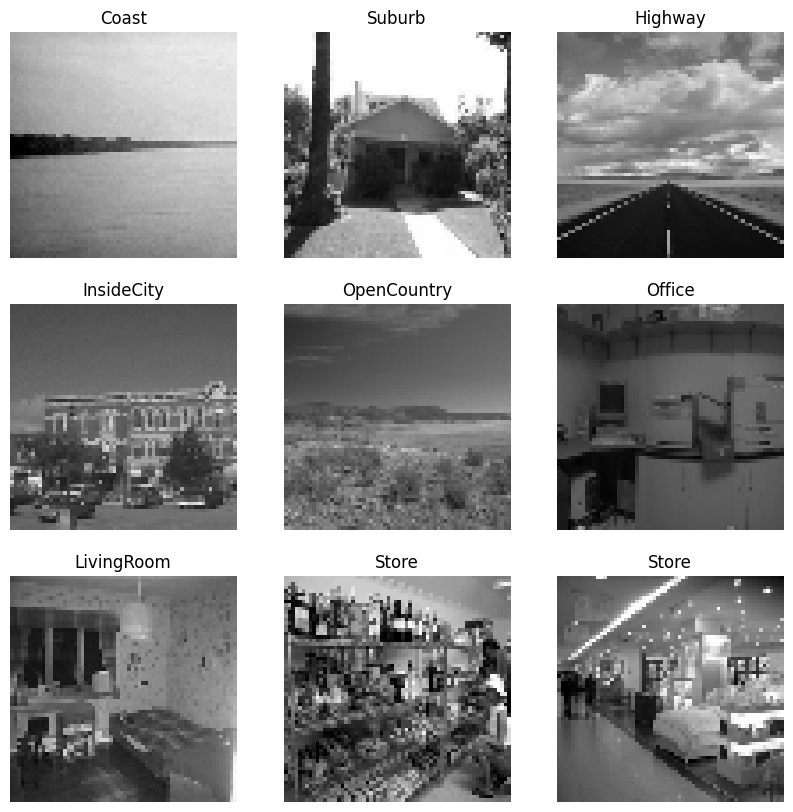

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Normalization layer
Create a normalization layer to scale inputs into a distribution centered around 0 with standard deviation 1
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization

In [16]:
# Initialize the normalization layer
normalizer = layers.Normalization(axis=None)

# A Normalization layer should always either be adapted over a dataset or passed mean and variance.
# Adapt it to the training images
# Note: the dataset object contains both the images and the labels (need to adapt it over the iamges only)
train_feature_ds = train_ds.map(lambda x, y:x)
normalizer.adapt(train_feature_ds)

## Create a Simple Net


In [20]:
# Create a TF sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', seed=0),
])

"""
This function will build a simple Sequential model.
The model will normalize the input data and perform data augmentation.

The function will also compile the model with the Adam optimiser, a cross
entropy loss function, and a single accuracy metric.
"""
def get_simple_aug_model(input_shape):
    # Construct the model
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = normalizer(inputs)
    x = data_augmentation(x)
    x = tf.keras.layers.Conv2D(10, kernel_size=(5,5), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Conv2D(20, (5,5), activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(500)(x)
    x = tf.keras.layers.Dense(100)(x)
    outputs = tf.keras.layers.Dense(15, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the Model and Return
    adam = tf.keras.optimizers.Adam()
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

#Get the model and print the model summary
desired_input_shape = train_ds.element_spec[0].shape[1:]
aug_model = get_simple_aug_model(desired_input_shape)
aug_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 normalization_1 (Normaliza  (None, 64, 64, 3)         3         
 tion)                                                           
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 20)        5020

### Define a function to evaluate a model's test accuracy

In [21]:
def get_test_accuracy(model, test_ds):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    return test_acc

# Calculate initial test accuracy (without any training)
test_aug = get_test_accuracy(aug_model, test_ds)

accuracy: 0.064


### Train the simple augmented model

In [22]:
# Fit the model with the training data
aug_history = aug_model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
47/47 [==============================] - 2s 11ms/step - loss: 2.7452 - accuracy: 0.1153 - val_loss: 2.5308 - val_accuracy: 0.1685
Epoch 2/30
47/47 [==============================] - 0s 11ms/step - loss: 2.2093 - accuracy: 0.2987 - val_loss: 2.1076 - val_accuracy: 0.3250
Epoch 3/30
47/47 [==============================] - 1s 14ms/step - loss: 1.8290 - accuracy: 0.4033 - val_loss: 1.9048 - val_accuracy: 0.3869
Epoch 4/30
47/47 [==============================] - 1s 14ms/step - loss: 1.5596 - accuracy: 0.4960 - val_loss: 1.7248 - val_accuracy: 0.4389
Epoch 5/30
47/47 [==============================] - 1s 12ms/step - loss: 1.3691 - accuracy: 0.5613 - val_loss: 1.6804 - val_accuracy: 0.4519
Epoch 6/30
47/47 [==============================] - 0s 10ms/step - loss: 1.2734 - accuracy: 0.5807 - val_loss: 1.6742 - val_accuracy: 0.4714
Epoch 7/30
47/47 [==============================] - 0s 10ms/step - loss: 1.2327 - accuracy: 0.6020 - val_loss: 1.5507 - val_accuracy: 0.4958
Epoch 8/30
47

In [23]:
# Test after fitting
test_aug = get_test_accuracy(aug_model, test_ds)

accuracy: 0.517


94/94 [==============================] - 0s 2ms/step
(2985,)
(2985,)


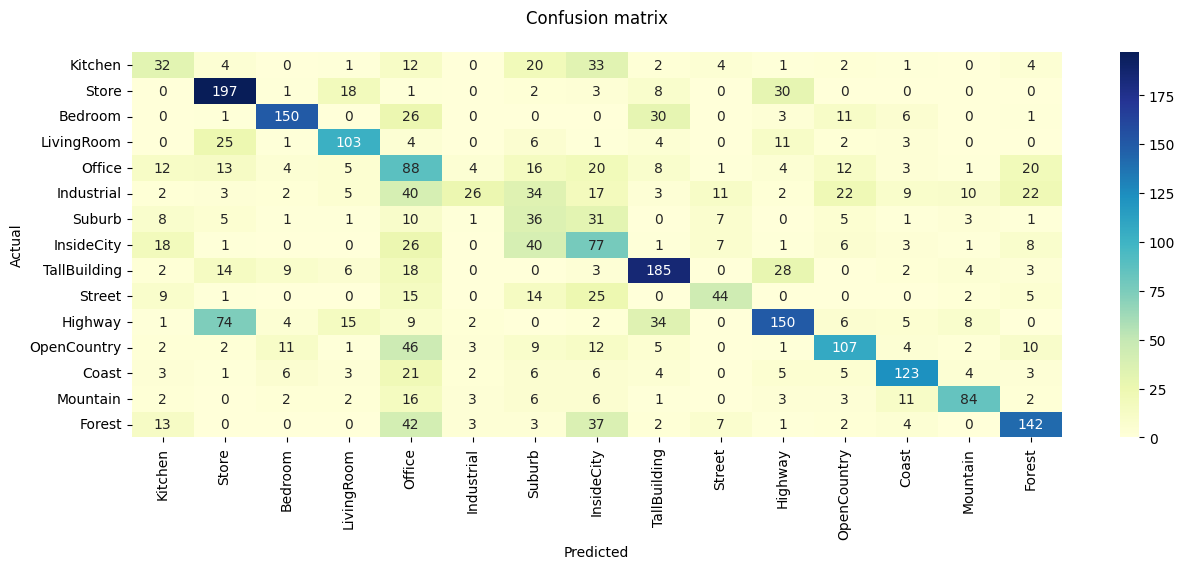

In [24]:
# Since test set was shuffled, cache without shuffling. OTherwise the results will be erroneous.
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
cm = confMat(aug_model,test_ds)

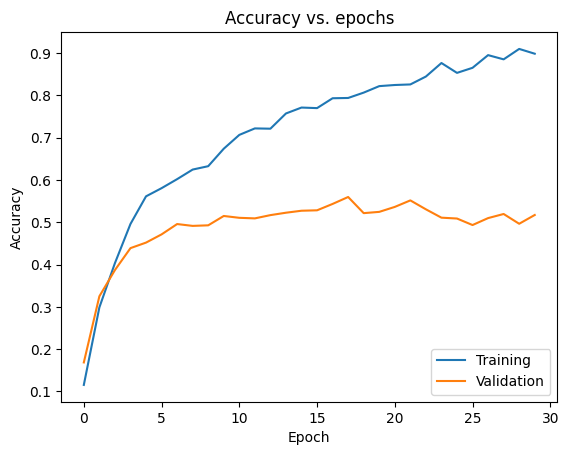

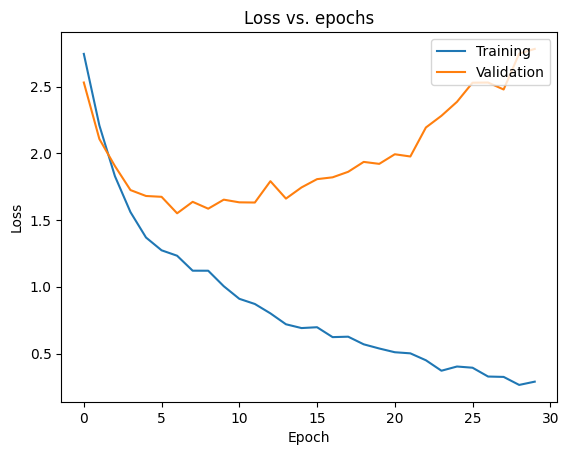

In [25]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(aug_history)
plotLoss(aug_history)


## Regularization

The network is overfitting, the next model will attempt to mitigate this problem.

In [26]:
"""
This function will update the previous model by incorporating kernel regularization (weight decay) and
Dropout layer and BatchNormalization layer.
This model keeps the normalization and data augmentation layers as well.
The function will also compile the model with the Adam optimiser, a cross
entropy loss function, and a single accuracy metric.
"""
def get_simple_regularized_model(input_shape, wd, rate):
    # Construct the model
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = normalizer(inputs)
    x = data_augmentation(x)
    x = tf.keras.layers.Conv2D(10, kernel_size=(5,5), activation="relu", kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Conv2D(20, (5,5), activation="relu", kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.MaxPooling2D((3,3))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(500, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dense(100, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(15, activation="softmax", kernel_regularizer=regularizers.L2(l2=wd))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the Model and Return
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

In [27]:
# Get the model and fit it with the training data, testing against the validation test data
aug_reg_model = get_simple_regularized_model(desired_input_shape, 1e-3, 0.5)
aug_reg_history = aug_reg_model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
47/47 [==============================] - 8s 15ms/step - loss: 3.9663 - accuracy: 0.1007 - val_loss: 3.4633 - val_accuracy: 0.1186
Epoch 2/30
47/47 [==============================] - 1s 11ms/step - loss: 3.6127 - accuracy: 0.1500 - val_loss: 3.3723 - val_accuracy: 0.1682
Epoch 3/30
47/47 [==============================] - 1s 11ms/step - loss: 3.4899 - accuracy: 0.1747 - val_loss: 3.0712 - val_accuracy: 0.2412
Epoch 4/30
47/47 [==============================] - 1s 11ms/step - loss: 3.3385 - accuracy: 0.2360 - val_loss: 3.0428 - val_accuracy: 0.2714
Epoch 5/30
47/47 [==============================] - 1s 12ms/step - loss: 3.2902 - accuracy: 0.2447 - val_loss: 3.0162 - val_accuracy: 0.2660
Epoch 6/30
47/47 [==============================] - 1s 11ms/step - loss: 3.1231 - accuracy: 0.2747 - val_loss: 2.9564 - val_accuracy: 0.2901
Epoch 7/30
47/47 [==============================] - 1s 12ms/step - loss: 3.0630 - accuracy: 0.2927 - val_loss: 2.9439 - val_accuracy: 0.2928
Epoch 8/30
47

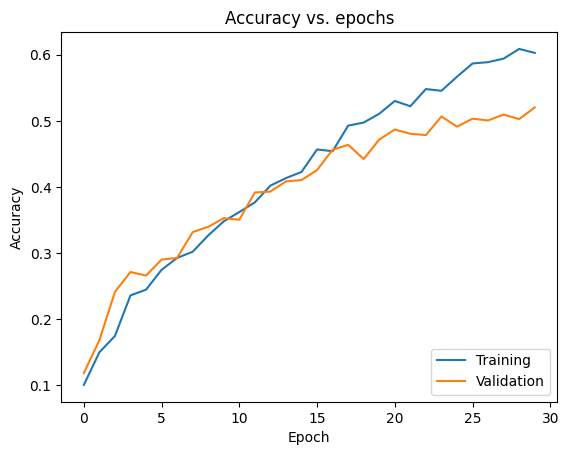

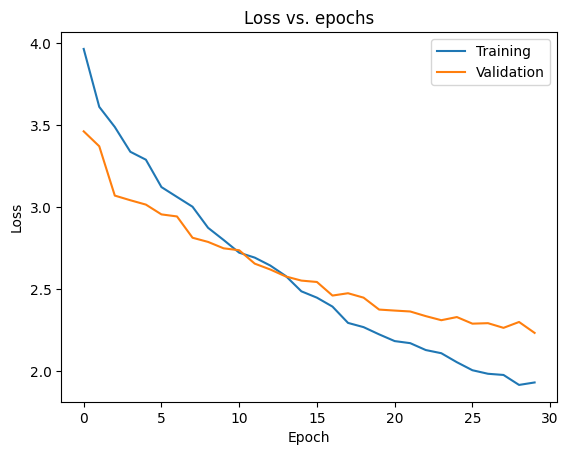

In [28]:
plotAccuracy(aug_reg_history)
plotLoss(aug_reg_history)

In [29]:
test_reg = get_test_accuracy(aug_reg_model, test_ds)

accuracy: 0.520


94/94 [==============================] - 0s 2ms/step
(2985,)
(2985,)


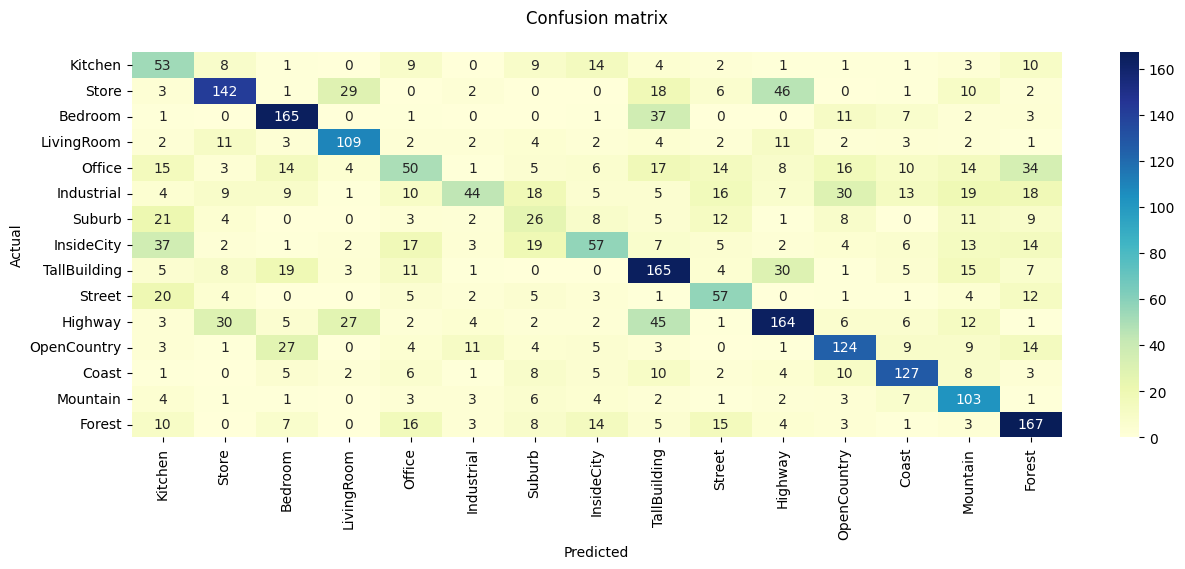

In [30]:
# Plot confusion matrix for model.
cm = confMat(aug_reg_model,test_ds)

## Transfer Learning and Fine-tuning using Resnet50

Let us pre-process the images so that it is ready to be input to the Resnet50 model

In [31]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [37]:
# New data augmentation
data_aug = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal', seed=0),
  tf.keras.layers.RandomRotation(0.2, seed=0),
])

"""
This function will create a model derived from Resnet50.
    It will include all but the last layer of Resnet50 (essentially the output should have a shape of (None, 2048)).
    More layers will be added based on experimentation and fine-tuning.
    The layers of the ResNet50 will be trainable.
The input shape of the Resnet50 is set using the input_shape argument, given by the
function argument.

The function will also compile the model with the Adam optimiser with a learning rate of 0.0001,
a sparse categorical cross entropy loss function, and a single accuracy metric.
"""
def get_TL_model(input_shape):
    wd = 1e-3
    rate = 0.7

    # Get input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Use the input layer to initialize the ResNet50 model and set the model to trainable
    resnet50_model = ResNet50(include_top=False, input_shape=input_shape, pooling="max", classes=15, input_tensor=inputs)
    resnet50_model.trainable=True

    # Construct the rest of the model
    x = data_aug(inputs)
    x = resnet50_model(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(500, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(250, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(15, kernel_regularizer=regularizers.L2(l2=wd), activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the Model and Return
    adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

# Get the model and print the summary
model_TL = get_TL_model(desired_input_shape)
model_TL.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 500)               1024500   
                                                           

In [38]:
# Use checkpoint for best and early stopping callback and then fit the model with the training data
checkpoint_best_only = ModelCheckpoint(filepath='/checkpoint_best_only/checkpoint', save_freq='epoch', monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 3, mode = 'max', verbose = 1)
new_history = model_TL.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[checkpoint_best_only, early_stopping])

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 4.7368 - accuracy: 0.0707
Epoch 1: val_accuracy improved from -inf to 0.11089, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 39s 176ms/step - loss: 4.7368 - accuracy: 0.0707 - val_loss: 4.4167 - val_accuracy: 0.1109
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 4.6587 - accuracy: 0.0760
Epoch 2: val_accuracy improved from 0.11089 to 0.22580, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 7s 157ms/step - loss: 4.6587 - accuracy: 0.0760 - val_loss: 3.7776 - val_accuracy: 0.2258
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 4.5159 - accuracy: 0.0860
Epoch 3: val_accuracy improved from 0.22580 to 0.28710, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 8s 164ms/step - loss: 4.5159 - accuracy: 0.0860 - val_loss: 3.6225 - val_accuracy: 0.2871
Epoch 4/50
4

In [39]:
"""
This function will create a new instance of the CNN created earlier, load
on the weights leading to the highest validation accuracy, and return this model.
"""
def get_model_best_epoch(model):
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir="/checkpoint_best_only/"))

    return model

model_TL = get_model_best_epoch(get_TL_model(desired_input_shape))
test_TL = get_test_accuracy(model_TL, test_ds)

accuracy: 0.744


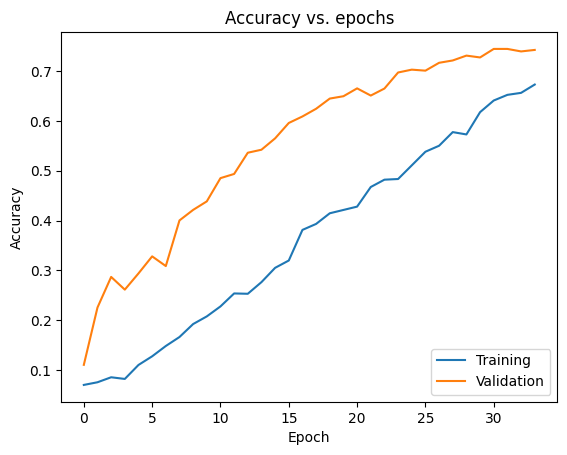

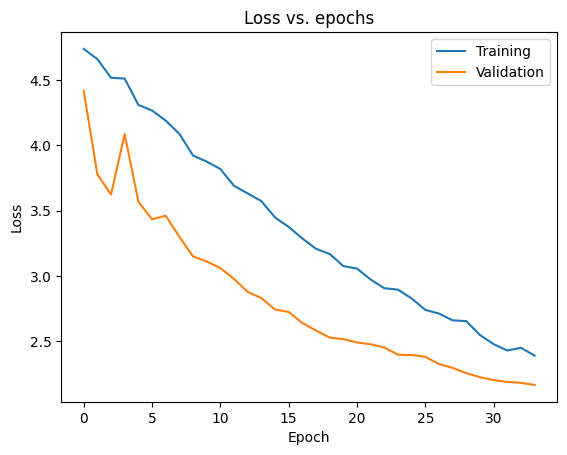

In [40]:
#Run this cell to plot the new loss vs epoch graph
plotAccuracy(new_history)
plotLoss(new_history)

94/94 [==============================] - 3s 16ms/step
(2985,)
(2985,)


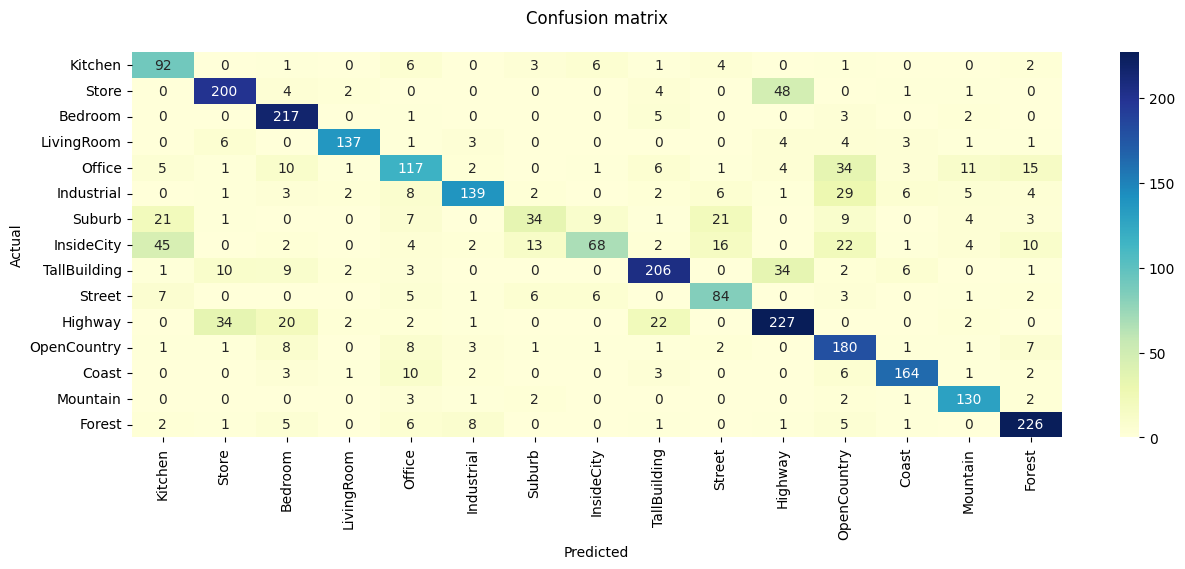

In [41]:
cm = confMat(model_TL,test_ds)

### Improve the performance further.

In [42]:
# Get the data again for preprocessing
train_ds = make_ds(data_dir_train, IMG_SIZE)
test_ds = make_ds(data_dir_test, IMG_SIZE)
train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

# preprocess the data for the VGG19 model
def preprocess(images, labels):
  return tf.keras.applications.vgg16.preprocess_input(images), labels

# Preprocessed data
train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# Get an improved model using a new transfer model
def get_improved_TL_model(input_shape):
    wd = 0.0001
    rate = 0.5

    # Get the VGG19 model and freeze the first 17 layers
    VGG19_model = tf.keras.applications.VGG19(include_top=False, input_shape=input_shape, pooling="max", classifier_activation='softmax')
    for layer in VGG19_model.layers[:17]:
      layer.trainable=False

    # Construct the rest of the model
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = VGG19_model(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(500, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(250, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, kernel_regularizer=regularizers.L2(l2=wd))(x)
    x = tf.keras.layers.Dropout(rate=rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(15, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the Model and Return
    expo_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=3e-5, decay_steps=1000, decay_rate=0.9)
    adam = tf.keras.optimizers.Adam(learning_rate=expo_decay)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=adam, loss=loss_func, metrics=["accuracy"])

    return model

# Get the model and display the summary
big_input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
new_model_TL = get_improved_TL_model(big_input_shape)
new_model_TL.summary()

Found 1500 files belonging to 15 classes.
Found 2985 files belonging to 15 classes.
80134624/80134624 [==============================] - 3s 0us/step
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_7 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_17 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 500)               256500    
                                          

In [43]:
# Get the callbacks and then fit the new model with the training data
checkpoint_best_only = ModelCheckpoint(filepath='/checkpoint_best_only/checkpoint', save_freq='epoch', monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5, mode = 'max', verbose = 1)
reduceLROnP = tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.2, min_lr=0.0000001)
new_history = new_model_TL.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[checkpoint_best_only, early_stopping, reduceLROnP])

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: 3.1801 - accuracy: 0.1113
Epoch 1: val_accuracy improved from -inf to 0.26399, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 49s 803ms/step - loss: 3.1801 - accuracy: 0.1113 - val_loss: 2.8266 - val_accuracy: 0.2640 - lr: 2.9855e-05
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: 2.5969 - accuracy: 0.2153
Epoch 2: val_accuracy improved from 0.26399 to 0.45695, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 33s 719ms/step - loss: 2.5969 - accuracy: 0.2153 - val_loss: 1.7959 - val_accuracy: 0.4570 - lr: 2.9707e-05
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: 2.2419 - accuracy: 0.3147
Epoch 3: val_accuracy improved from 0.45695 to 0.56516, saving model to /checkpoint_best_only/checkpoint
47/47 [==============================] - 30s 644ms/step - loss: 2.2419 - accuracy: 0.3147 - val_loss: 1.4769

In [44]:
new_model_TL = get_model_best_epoch(get_improved_TL_model(big_input_shape))
test_TL = get_test_accuracy(new_model_TL, test_ds)

accuracy: 0.895


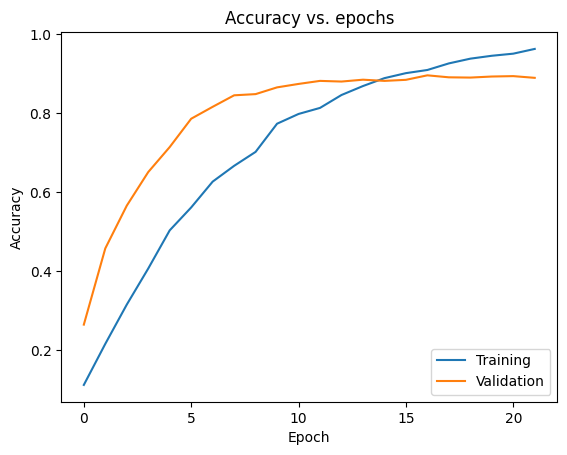

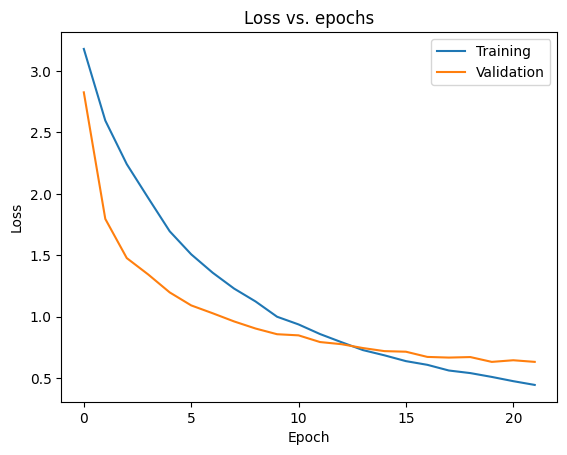

In [45]:
plotAccuracy(new_history)
plotLoss(new_history)

94/94 [==============================] - 17s 176ms/step
(2985,)
(2985,)


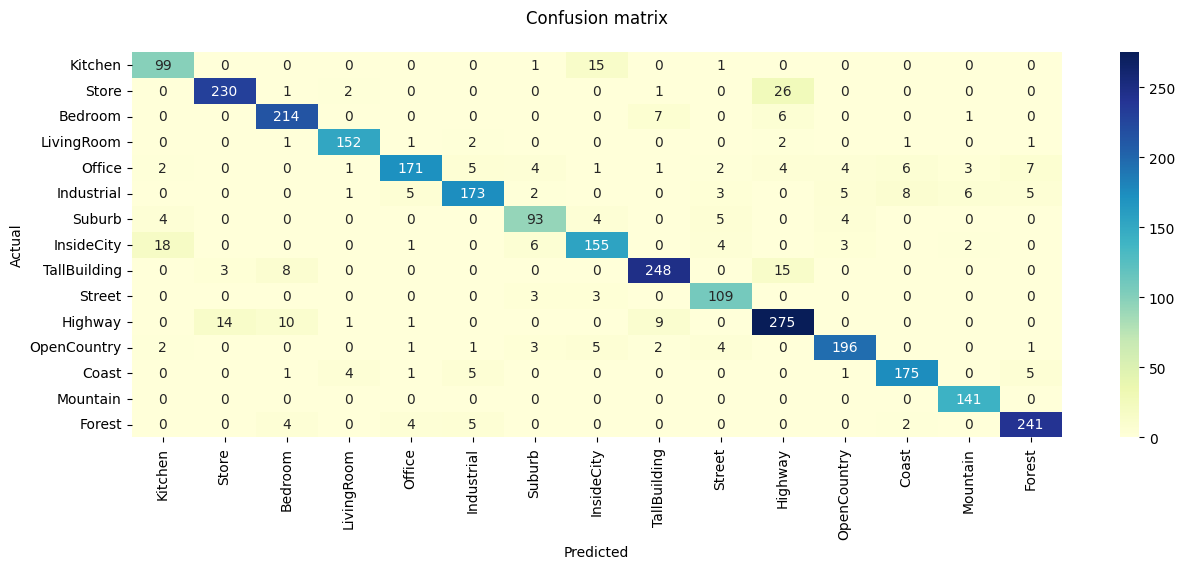

In [46]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
cm = confMat(new_model_TL,test_ds)